# Volve Production Data Analysis
This body of work is a python based data analysis on the Volve data set. Read about the Volve dataset here:
https://www.equinor.com/en/how-and-why/digitalisation-in-our-dna/volve-field-data-village-download.html

In short, The Volve dataset is provided by Equinor. Its a complete data set on a sub-sea asset. Its more data than I have ever seen provided by any other E&P. Its glorious. 

The data analysis path I will follow is:
-Plot the production data and visually examine and explore
-Map the Data
-Do the wells talk to each other?


"""
                

unique days 3327
Flow Kinds? ['production' 'injection']
There are 6 producers
Production Wells: [7405, 7078, 5599, 5351, 7289, 5769]
There are 3 injectors
Injection Wells: [7405 5693 5769]
onto inj data stacked
onto inj by well


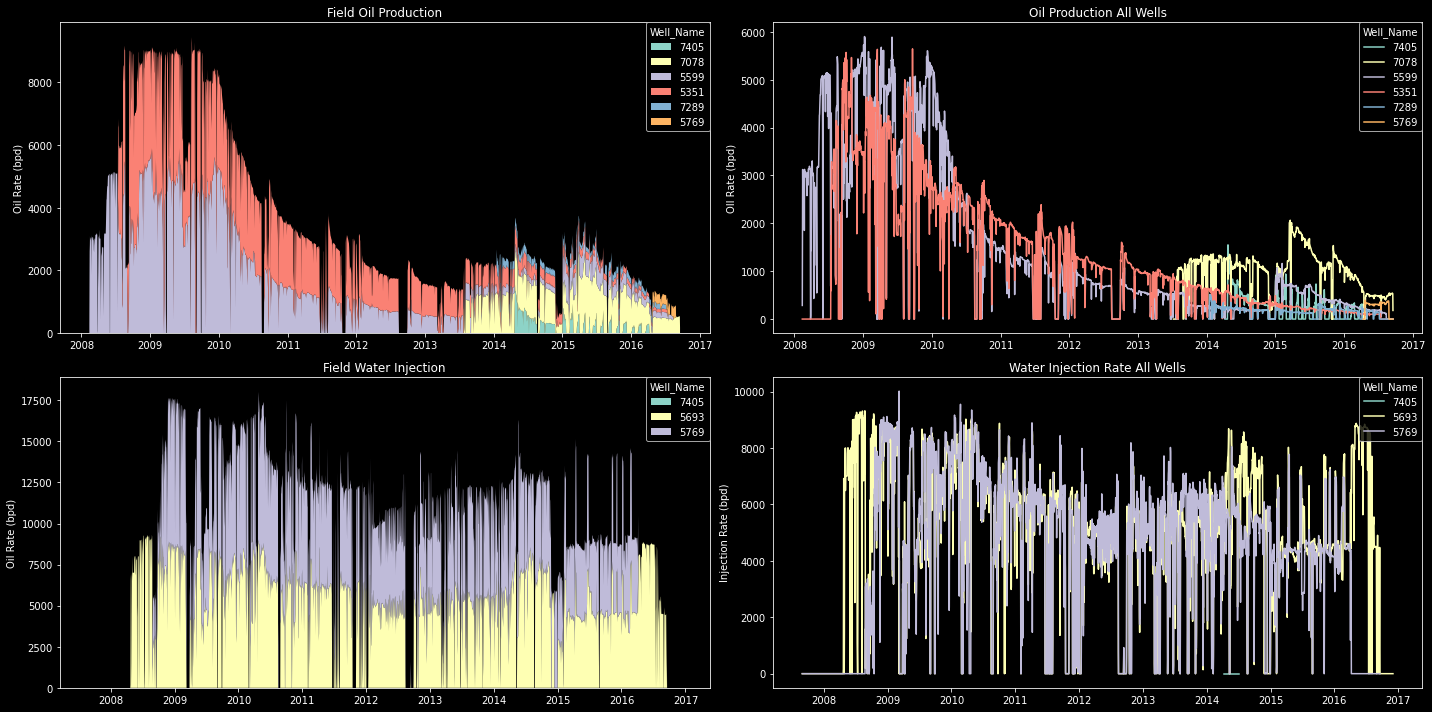

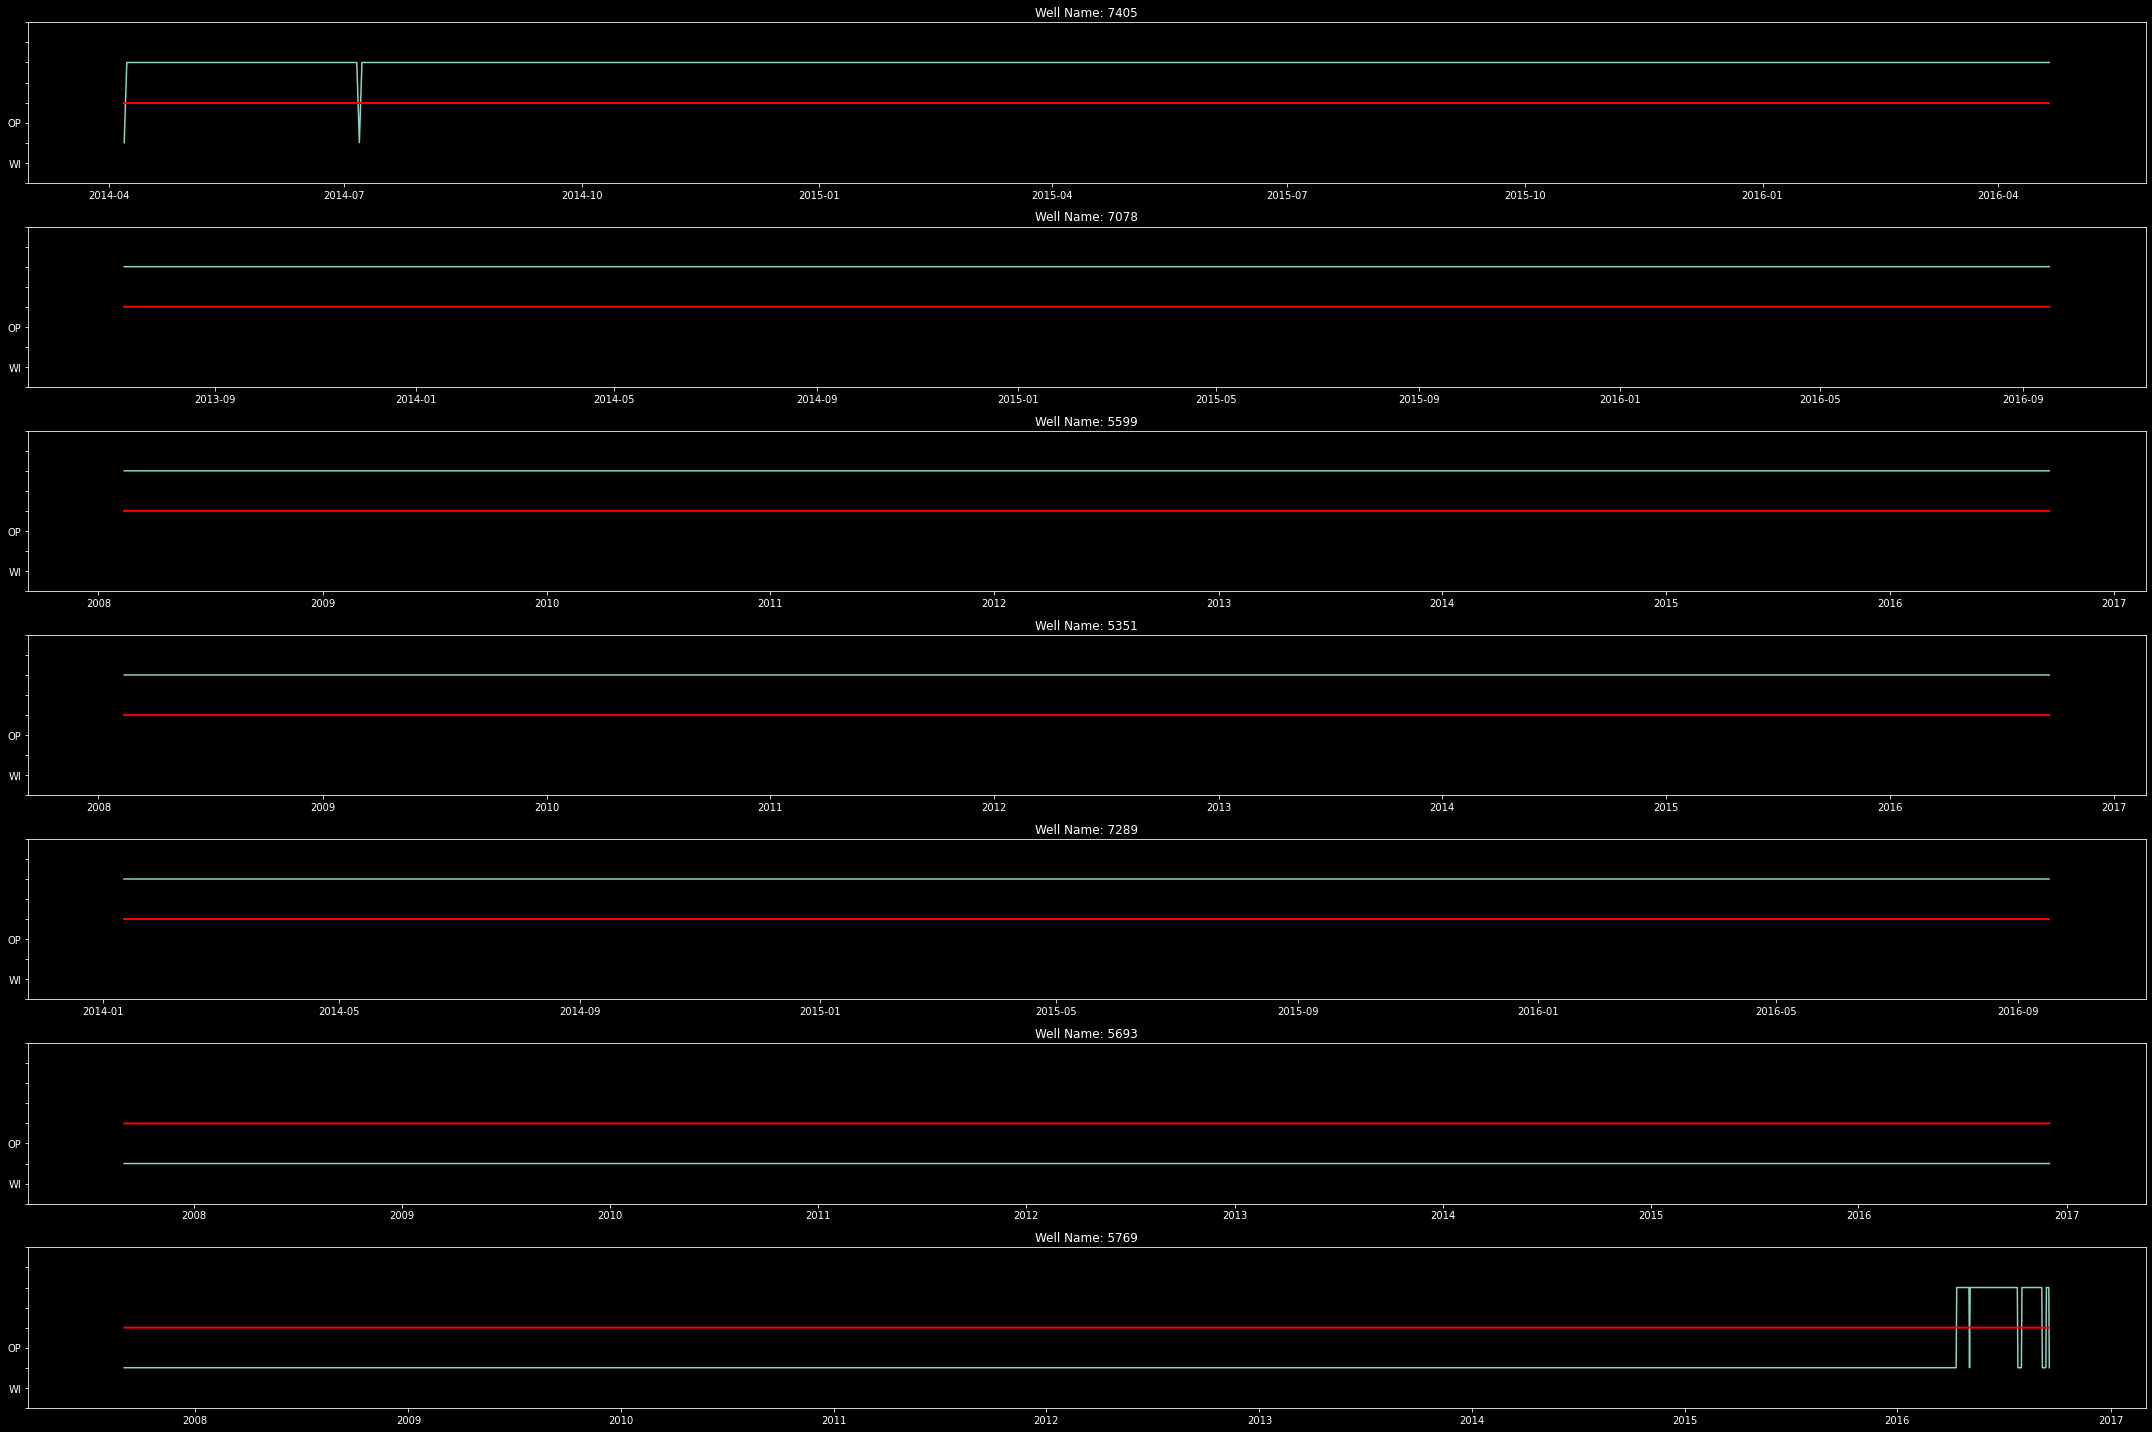

In [1]:
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import numpy as np

plt.style.use('dark_background')

xls = pd.ExcelFile('Volve production data.xlsx')
sheets = [xls.sheet_names]

"""
Open the production data spreadsheet and parse the data into dataframes
"""
try:
    dd_df = pd.read_excel(xls, 'Daily Production Data')
    mm_df = pd.read_excel(xls, 'Monthly Production Data')
    loc_df = pd.read_excel(xls, 'Locations')
except:
    print('No file or tab in file')

"""Examine the daily data and convert into a useful dataframe""" 

dd_df['DateStamp'] = dd_df['DATEPRD']
print('unique days',len(dd_df['DATEPRD'].unique()))
dd_df['DateStamp'] = pd.to_datetime(dd_df['DateStamp'])
dd_df.index = dd_df['DateStamp']
dd_df.fillna(0.0, inplace=True)

#print(list(dd_df))
"""
['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME', 'NPD_FIELD_CODE', 
'NPD_FIELD_NAME', 'NPD_FACILITY_CODE', 'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 
'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 
'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 
'BORE_GAS_VOL', 'BORE_WAT_VOL', 'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE', 'DateStamp']
"""


#Determine if there are producers and injectors, and make a list of each
print('Flow Kinds?', dd_df['FLOW_KIND'].unique())
# Injectors and Producers?
#Flow Kinds? ['production' 'injection']

#which ones?
prd_df = dd_df[dd_df['WELL_TYPE'] == 'OP']
prd_wells = prd_df['NPD_WELL_BORE_CODE'].unique().tolist()
print('There are {} producers'.format(len(prd_wells)))
print('Production Wells: {}'.format(prd_wells))

inj_df = dd_df[dd_df['WELL_TYPE'] == 'WI']
inj_wells = inj_df['NPD_WELL_BORE_CODE'].unique()
print('There are {} injectors'.format(len(inj_wells)))
print('Injection Wells: {}'.format(inj_wells))

# We need to pivot the production data to a long df with wells as columns to make a stacked chart
prod_by_well = pd.pivot_table(prd_df,index=['DATEPRD'],values=["BORE_OIL_VOL"],columns=["NPD_WELL_BORE_CODE"])

#convert to a non-pivoted dataframe
prod_by_well = pd.DataFrame(prod_by_well.to_records())
#rename columns
prod_by_well.columns = [hdr.replace("('BORE_OIL_VOL', ", "").replace(")", "") \
                     for hdr in prod_by_well.columns]
#fill in nans with 0.0. We have to do this because when the data is pivoterd we add new 
# "data" without values
prod_by_well.fillna(0.0, inplace=True)

# We need to pivot the injection data to a long df with wells as columns to make a stacked chart
inj_by_well = pd.pivot_table(inj_df,index=['DATEPRD'],values=["BORE_WI_VOL"],columns=["NPD_WELL_BORE_CODE"])

#convert to a non-pivoted dataframe
inj_by_well = pd.DataFrame(inj_by_well.to_records())
#rename columns
inj_by_well.columns = [hdr.replace("('BORE_WI_VOL', ", "").replace(")", "") \
                     for hdr in inj_by_well.columns]
#fill in nans with 0.0
inj_by_well.fillna(0.0, inplace=True)

#make a list of lists for the stacked plot
prod = []
for i in prd_wells:
    temp = prod_by_well[str(i)].to_list()
    prod.append(temp)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
#make a list of values for x
x = prod_by_well['DATEPRD'].tolist()
# Basic stacked area chart.
axes[0,0].stackplot(x,prod, labels = prd_wells)
axes[0,0].title.set_text('Field Oil Production')
axes[0,0].set_ylabel('Oil Rate (bpd)')
fig.tight_layout()
axes[0,0].legend(bbox_to_anchor=(1.0, 1), loc='upper right', borderaxespad=0., title = 'Well_Name')

for i in prd_wells:
    df = prd_df[prd_df['NPD_WELL_BORE_CODE'] == i]
    xh = df['DateStamp']
    yh = df['BORE_OIL_VOL']
    axes[0,1].plot(xh, yh, label = str(i))
    
axes[0,1].title.set_text('Oil Production All Wells')
axes[0,1].set_ylabel('OIl Rate (bpd)')
fig.tight_layout()
axes[0,1].legend(bbox_to_anchor=(1.0, 1), loc='upper right', borderaxespad=0., title = 'Well_Name')

print('onto inj data stacked')
inj = []
for i in inj_wells:
    temp = inj_by_well[str(i)].to_list()
    inj.append(temp)

x = inj_by_well['DATEPRD'].tolist()
# Basic stacked area chart.

axes[1,0].stackplot(x,inj, labels = inj_wells)
axes[1,0].title.set_text('Field Water Injection')
axes[1,0].set_ylabel('Oil Rate (bpd)')
fig.tight_layout()
axes[1,0].legend(bbox_to_anchor=(1.0, 1), loc='upper right', borderaxespad=0., title = 'Well_Name')
#ax1.plt.show()

print('onto inj by well')
for i in inj_wells:
    df = inj_df[inj_df['NPD_WELL_BORE_CODE'] == i]
    xh = df['DateStamp']
    yh = df['BORE_WI_VOL']
    axes[1,1].plot(xh, yh, label = str(i))
    
axes[1,1].title.set_text('Water Injection Rate All Wells')
axes[1,1].set_ylabel('Injection Rate (bpd)')
fig.tight_layout()
axes[1,1].legend(bbox_to_anchor=(1.0, 1), loc='upper right', borderaxespad=0., title = 'Well_Name')

plt.show()

"""Now we can do a little bit of visual analysis.
Lets see what wells were injectors and producers 
over the life of the field"""

inj_prod_dict = {'OP' : 1 , 'WI' : -1}

dd_df['inj_prod'] = dd_df['WELL_TYPE'].map(inj_prod_dict)
well_list = dd_df['NPD_WELL_BORE_CODE'].unique().tolist()

well_num = len(dd_df['NPD_WELL_BORE_CODE'].unique())

fig, ax0 = plt.subplots(nrows=7, ncols=1, figsize=(30, 20))
j = 0
for i in well_list:
    df = dd_df[dd_df['NPD_WELL_BORE_CODE'] == i]
    x = df['DateStamp']
    y = df['inj_prod']
    zero = [0 for i in range(len(df))]
    ax0[j].plot(x, y)
    ax0[j].set_ylim(-2,2)
    ax0[j].title.set_text('Well Name: {}'.format(str(i)))
    ax0[j].plot(x, zero, color = 'red', lw=2)
    ax0[j].set_yticklabels(('','WI','','OP'))
    fig.tight_layout()
    #set_xticks(ticks, minor=False)
    j = j + 1
plt.show()

In [ ]:
    
""" The green line is the state of the well. It can be a producer 
(OP) if its above the red line, or an injector (WI) if its below
the red line. Well name 7405 spent two tiny stints as an injector. 
On reviewing the WI data no water was injected. Obviously an error
in the dataset. Wells 5693 and 5769 spent quite alot of time as 
injectors. Well 5769 was converted to a producer around Q2 2016"""

"""Lets see where everything maps to get a sense of the spatial 
arrangement of injectors and producers. To get the location data 
I had to scrape it from the drilling reports and added the data
to the production data spreadsheet. The well collars are subsea
so we cant make a classical topography map because, well, there
is no topology. """


from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

#output_file("tile.html")

tile_provider = get_provider(CARTODBPOSITRON)

# range bounds supplied in web mercator coordinates
p = figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

show(p)

In [ ]:
"""There are 7 wells total. """
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

# Your x and y axis
x=range(1,6)
y=[ [1,4,6,8,9], [0,0,7,10,12], [2,8,5,10,6] ]
 
# Basic stacked area chart.
plt.stackplot(x,y, labels=['A','B','C'])
plt.legend(loc='upper left')
#plt.show()
#print(dd_df)
prod_list = []
dd_df.fillna(value=0.0)
for i in well_names:
    data = dd_df['BORE_OIL_VOL'][dd_df['NPD_WELL_BORE_CODE'] == i].fillna(value=0).values.tolist()
    prod_list.append(data)
    
#print(prod_list[1])
print(len(prod_list[0]))
print(len(prod_list[1]))
print(len(prod_list[2]))
#print(prod_list)
#df2 = dd_df['BORE_OIL_VOL'][dd_df['NPD_WELL_BORE_CODE'] == 7078].fillna(value=0).values.tolist()
#df.values.tolist()
#prod = df['BORE_OIL_VOL'].values.tolist()
#print(prod)
#print(df1)
#all_df = []
#all_df.append(df1)
#all_df.append(df2)
#print(all_df)
#many = list(zip(df1,df2))
#print(type(many))
#print(many)
#print(len(prod_list[1]))
#xs = range(1,len(df))
#print(type(prod_list))
#plt.stackplot(xs,prod_list)
#plt.legend(loc='upper left')
#print(type(prod_list))
#print(prod_list)
#bert = pd.DataFrame(prod_list, columns=["colummn"])
#print(bert)
#from tabulate import tabulate
#print(tabulate(prod_list))


